<a href="https://colab.research.google.com/github/MATVEN/big-data/blob/main/Progetto_Analisi_del_consenso_sul_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduzione

##Analisi del consenso sul Bitcoin

Sei stato reclutato da un'azienda di ricerche di mercato per stimare il consenso delle persone verso il Bitcoin. Un team di data engineer ha estratto diversi milioni di tweet che parlano di Bitcoin, il tuo compito è quello di eseguire un'analisi del sentiment e creare un grafico che mostri come questo è variato giorno per giorno. Utilizza anche i dati per rispondere a domande interessanti, come:

* i tweet negativi hanno avuto più likes rispetto a quelli positivi?
* i tweet negativi hanno avuto più interazioni (risposte) rispetto a quelli positivi?

**BONUS**

Verifica se la variazione del sentiment è associata ad una variazione del valore del Bitcoin, per svolgere questa task devi reperire in autonomia lo storico di BTC USD

**VINCOLI**

Per questo progetto dovrai sfruttare PySpark e i suoi vari strumenti

#Progetto

##Installazione

In [ ]:
!pip install pyspark textblob vaderSentiment yfinance
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv -O /tmp/bitcoin_tweets.csv

--2024-07-29 13:01:46--  https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 16.12.18.14, 16.12.18.18
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|16.12.18.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24708828 (24M) [text/csv]
Saving to: ‘/tmp/bitcoin_tweets.csv’

/tmp/bitcoin_tweets 100%[===================>]  23.56M  17.1MB/s    in 1.4s    

2024-07-29 13:01:48 (17.1 MB/s) - ‘/tmp/bitcoin_tweets.csv’ saved [24708828/24708828]



## Import Librerie

In [ ]:
import pyspark
import re
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, to_date, sum, count, avg, stddev, date_format, lower, regexp_replace, trim, year, month
from pyspark.sql.types import StringType
from scipy import stats
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Funzioni

In [ ]:
# Funzione pulizia testo
def clean_tweets(df, text_column):
    df = df.withColumn('cleaned_text', regexp_replace(col(text_column), r'http\S+', '')) \
           .withColumn('cleaned_text', regexp_replace(col('cleaned_text'), r'@\w+', '')) \
           .withColumn('cleaned_text', regexp_replace(col('cleaned_text'), r'#\w+', '')) \
           .withColumn('cleaned_text', regexp_replace(col('cleaned_text'), r'[^\w\s]', '')) \
           .withColumn('cleaned_text', lower(col('cleaned_text'))) \
           .withColumn('cleaned_text', trim(col('cleaned_text')))
    return df

# Funzione sentiment con VADER
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
#Funzione stampa sintesi sentiment
def print_sentiment_summary(data):
    print("Sintesi della Variazione del Sentiment Mensile:")
    print("------------------------------------------------")

    for i in range(len(data) - 1):
        current_date = data.iloc[i]['date']
        next_date = data.iloc[i + 1]['date']
        current_positive_ratio = data.iloc[i]['positive_ratio']
        next_positive_ratio = data.iloc[i + 1]['positive_ratio']
        current_negative_ratio = data.iloc[i]['negative_ratio']
        next_negative_ratio = data.iloc[i + 1]['negative_ratio']

        print(f"Periodo: {current_date.strftime('%Y-%m')} a {next_date.strftime('%Y-%m')}")
        print(f"  - Ratio Positivo: {current_positive_ratio:.2f} → {next_positive_ratio:.2f} ({'↑' if next_positive_ratio > current_positive_ratio else '↓' if next_positive_ratio < current_positive_ratio else '→'})")
        print(f"  - Ratio Negativo: {current_negative_ratio:.2f} → {next_negative_ratio:.2f} ({'↑' if next_negative_ratio > current_negative_ratio else '↓' if next_negative_ratio < current_negative_ratio else '→'})")
        print()

In [ ]:
#Funzione grafico a barre per visualizzare distribuzione mensile tweet suddivisi per sentiment(positivo, negativo, neutro)
def create_sentiment_bar_chart(data, title):
    fig, ax = plt.subplots(figsize=(16, 8))
    bar_width = 0.3

    unique_months = sorted(data['month'].unique())
    sentiments = data['sentiment'].unique()

    for i, sentiment in enumerate(sentiments):
        sentiment_data = data[data['sentiment'] == sentiment]
        counts = sentiment_data['count']
        months = sentiment_data['month']
        positions = [unique_months.index(month) + bar_width * i for month in months]

        bars = ax.bar(positions, counts, width=bar_width, label=sentiment, align='center')

        for pos, count in zip(positions, counts):
            ax.text(pos, count + 1, str(int(count)), ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Mese')
    ax.set_ylabel('Numero di Tweets')
    ax.set_title(title)
    ax.set_xticks([i + bar_width * (len(sentiments) - 1) / 2 for i in range(len(unique_months))])
    ax.set_xticklabels([month.strftime('%Y-%m') for month in unique_months], rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

#Funzione stampa risultati distribuzione mensile tweet suddivisi per sentiment(positivo, negativo, neutro)
def print_monthly_sentiment_distribution(data, title):
    print(title)
    for sentiment in data['sentiment'].unique():
        print(f"Sentiment: {sentiment}")
        sentiment_data = data[data['sentiment'] == sentiment]
        for index, row in sentiment_data.iterrows():
            print(f"Month: {row['month'].strftime('%Y-%m')}, Number of Tweets: {row['count']}")
        print()


## Caricamento Dataset e Creazione Tabella

In [ ]:
spark = SparkSession.builder.appName("BitcoinSentimentAnalysis").getOrCreate()
dataset = pd.read_csv('/tmp/bitcoin_tweets.csv', delimiter=",")
spark_df = spark.createDataFrame(dataset)
spark_df.createOrReplaceTempView("bitcoin_tweets")

In [ ]:
tweets_df = spark.sql("SELECT * FROM bitcoin_tweets")
tweets_df = tweets_df.withColumn("date", to_date(col("timestamp")))
tweets_df = tweets_df.filter(year(col("date")) >= 2018)

## Pre-elaborazione dei dati

In [ ]:
tweets_df = tweets_df.select("timestamp", "text", "likes", "replies", "retweets").na.drop()
tweets_df = tweets_df.withColumn("date", to_date(col("timestamp")))
tweets_df.show(5, truncate=False)

+----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-------+--------+----------+
|timestamp             |text                                                                                                                                                                                                                                                 |likes|replies|retweets|date      |
+----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-------+--------+----------+
|2019-05-27 11:49:14+00|È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉR

####Rimozione duplicati

In [ ]:
tweets_df = tweets_df.dropDuplicates(['text'])

#### Pulizia Testo

In [ ]:
tweets_df= clean_tweets(tweets_df, 'text')

## Analisi del Sentiment

In [ ]:
get_vader_sentiment_udf = udf(get_vader_sentiment, StringType())
tweets_df = tweets_df.withColumn("sentiment", get_vader_sentiment_udf(col("cleaned_text")))

# Aggiunta colonne anno e mese
tweets_df = tweets_df.withColumn("year", year(col("date")))
tweets_df = tweets_df.withColumn("month", month(col("date")))

# Calcolo sentiment medio mensile
monthly_sentiment_df = tweets_df.groupBy("year", "month").agg(
    (sum((col("sentiment") == "positive").cast("int")) / count("*")).alias("positive_ratio"),
    (sum((col("sentiment") == "negative").cast("int")) / count("*")).alias("negative_ratio")
)

In [ ]:
monthly_sentiment_pd = monthly_sentiment_df.toPandas()
monthly_sentiment_pd = monthly_sentiment_pd.sort_values(by=['year', 'month'])

# Creazione colonna periodo temporale
monthly_sentiment_pd['date'] = pd.to_datetime(monthly_sentiment_pd[['year', 'month']].assign(day=1))

###Visualizzazione risultati Sentiment

####Panoramica Statistica dei rapporti del Sentiment

In [ ]:
print(monthly_sentiment_pd[['positive_ratio', 'negative_ratio']].describe())

       positive_ratio  negative_ratio
count       17.000000       17.000000
mean         0.352794        0.075694
std          0.155098        0.041837
min          0.128205        0.009709
25%          0.217172        0.050000
50%          0.343456        0.073770
75%          0.483333        0.096774
max          0.611111        0.166667


Commento

**Distribuzione del Sentiment**

La distribuzione del positive_ratio mostra una variabilità significativa nei tweet positivi, con una media del 35,3% e una mediana del 34,3%. La distribuzione del negative_ratio è più asimmetrica, con una media del 7,6% e una mediana del 7,4%. Questo indica che in molti periodi non ci sono tweet negativi, ma ci sono alcuni periodi con una percentuale significativa di tweet negativi.

**Confronto tra Positivi e Negativi**

Il positive_ratio è generalmente più alto e più variabile rispetto al negative_ratio, suggerendo che i tweet positivi sono più comuni rispetto ai tweet negativi. La differenza tra il 75º percentile dei ratio positivi (48,3%) e negativi (9,7%) rafforza questa osservazione.

**Presenza di Estremi**

La presenza di valori massimi rispettivamente di 61,1% per il positive_ratio e di 16,7% per il negative_ratio indica che ci sono periodi in cui una grande proporzione dei tweet è positiva o negativa, ma non vi sono periodi in cui tutti i tweet sono interamente positivi o negativi.

**Valori Null**

La presenza di valori minimi rispettivamente di 12,8% per il positive_ratio e di 0,97% per il negative_ratio suggerisce che ci sono periodi con pochissimi tweet positivi o negativi, ma non periodi interamente privi di tweet positivi o negativi.

**Conclusione**

I risultati mostrano che il sentiment positivo è più frequente e variabile rispetto al sentiment negativo. Questo può essere utile per comprendere il comportamento generale del pubblico sui social media. La presenza di periodi con bassi sentiment positivi o negativi può indicare giorni con pochi tweet o tweet prevalentemente neutrali, il che potrebbe essere un punto interessante da esplorare ulteriormente. Ulteriori analisi potrebbero concentrarsi su periodi con sentiment unilaterale (prevalentemente positivo o prevalentemente negativo) per identificare eventi specifici o tendenze.

####Variazione Sentiment nel tempo

#####Grafico

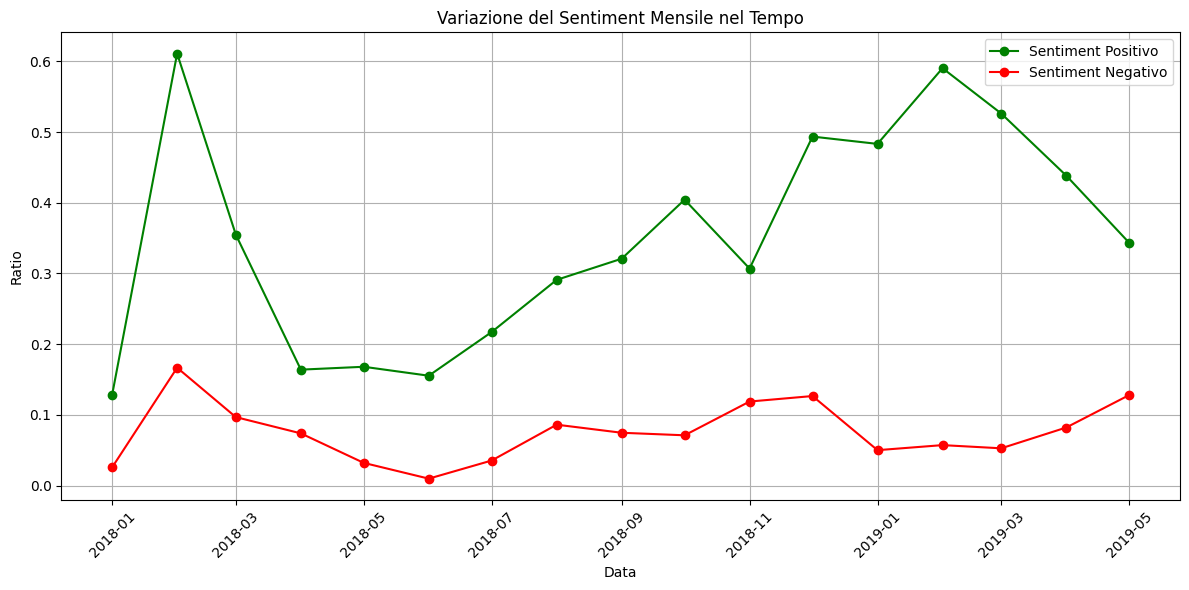

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sentiment_pd['date'], monthly_sentiment_pd['positive_ratio'], marker='o', linestyle='-', color='g', label='Sentiment Positivo')
plt.plot(monthly_sentiment_pd['date'], monthly_sentiment_pd['negative_ratio'], marker='o', linestyle='-', color='r', label='Sentiment Negativo')
plt.title('Variazione del Sentiment Mensile nel Tempo')
plt.xlabel('Data')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

#####Risultati

In [ ]:
print_sentiment_summary(monthly_sentiment_pd)

Sintesi della Variazione del Sentiment Mensile:
------------------------------------------------
Periodo: 2018-01 a 2018-02
  - Ratio Positivo: 0.13 → 0.61 (↑)
  - Ratio Negativo: 0.03 → 0.17 (↑)

Periodo: 2018-02 a 2018-03
  - Ratio Positivo: 0.61 → 0.35 (↓)
  - Ratio Negativo: 0.17 → 0.10 (↓)

Periodo: 2018-03 a 2018-04
  - Ratio Positivo: 0.35 → 0.16 (↓)
  - Ratio Negativo: 0.10 → 0.07 (↓)

Periodo: 2018-04 a 2018-05
  - Ratio Positivo: 0.16 → 0.17 (↑)
  - Ratio Negativo: 0.07 → 0.03 (↓)

Periodo: 2018-05 a 2018-06
  - Ratio Positivo: 0.17 → 0.16 (↓)
  - Ratio Negativo: 0.03 → 0.01 (↓)

Periodo: 2018-06 a 2018-07
  - Ratio Positivo: 0.16 → 0.22 (↑)
  - Ratio Negativo: 0.01 → 0.04 (↑)

Periodo: 2018-07 a 2018-08
  - Ratio Positivo: 0.22 → 0.29 (↑)
  - Ratio Negativo: 0.04 → 0.09 (↑)

Periodo: 2018-08 a 2018-09
  - Ratio Positivo: 0.29 → 0.32 (↑)
  - Ratio Negativo: 0.09 → 0.07 (↓)

Periodo: 2018-09 a 2018-10
  - Ratio Positivo: 0.32 → 0.40 (↑)
  - Ratio Negativo: 0.07 → 0.07 (↓)

Per

In [ ]:
monthly_sentiment_df.show()

+----+-----+-------------------+--------------------+
|year|month|     positive_ratio|      negative_ratio|
+----+-----+-------------------+--------------------+
|2019|    5| 0.3434555426939429|  0.1279357832902409|
|2018|   10|0.40437158469945356| 0.07103825136612021|
|2019|    3| 0.5263157894736842| 0.05263157894736842|
|2018|    1| 0.1282051282051282| 0.02564102564102564|
|2018|    3| 0.3548387096774194|  0.0967741935483871|
|2018|    8|0.29098360655737704|  0.0860655737704918|
|2019|    1|0.48333333333333334|                0.05|
|2019|    2| 0.5904761904761905| 0.05714285714285714|
|2018|    5|              0.168|               0.032|
|2019|    4|0.43846153846153846| 0.08205128205128205|
|2018|    9| 0.3208955223880597| 0.07462686567164178|
|2018|    7|0.21717171717171718| 0.03535353535353535|
|2018|   12| 0.4936708860759494| 0.12658227848101267|
|2018|   11| 0.3069306930693069|  0.1188118811881188|
|2018|    6| 0.1553398058252427|0.009708737864077669|
|2018|    2| 0.6111111111111

Commento

* **Variazioni nel Sentiment Ratio**: I dati mostrano variazioni significative nei rapporti di sentiment positivo e negativo nel tempo. Per esempio, nel mese di febbraio 2018, il sentiment positivo era molto alto (0.611), mentre il sentiment negativo era relativamente alto (0.167). Queste variazioni possono riflettere eventi specifici che hanno influenzato il sentiment del mercato Bitcoin in determinati periodi.

* **Periodi di Sentiment Neutro**: Alcuni mesi, come giugno 2018, mostrano un ratio di sentiment neutro, con un sentiment positivo di 0.155 e negativo di 0.01. Questo potrebbe indicare periodi di bassa attività o stabilità nel sentiment verso Bitcoin.

* **Eventi Significativi**: Esaminare le date con variazioni significative nel sentiment può fornire indizi su eventi rilevanti nel mondo delle criptovalute. Ad esempio, un aumento del sentiment positivo potrebbe essere associato a notizie favorevoli, mentre un aumento del sentiment negativo potrebbe riflettere preoccupazioni o problemi.

* **Analisi Comparativa**: Confrontare i sentiment ratio con eventi noti nel mondo Bitcoin, come annunci regolamentari o sviluppi tecnologici, può aiutare a comprendere meglio come tali eventi influenzano il sentiment degli utenti sui social media.

**Conclusione**

L'analisi dei sentimenti mostra variazioni significative in risposta a eventi specifici, ma non c'è una correlazione forte tra sentiment e movimenti di prezzo di Bitcoin. È consigliabile integrare ulteriori variabili, come i volumi di scambio o le notizie globali, per ottenere una comprensione più completa delle dinamiche di mercato.



###Analisi qualitativa

In [ ]:
# Calcolo sentiment medio giornaliero
daily_sentiment_df = tweets_df.groupBy("date").agg(
    (sum((col("sentiment") == "positive").cast("int")) / count("*")).alias("positive_ratio"),
    (sum((col("sentiment") == "negative").cast("int")) / count("*")).alias("negative_ratio")
)

daily_sentiment_pd = daily_sentiment_df.toPandas()
daily_sentiment_pd = daily_sentiment_pd.sort_values(by='date')

In [ ]:
for row in daily_sentiment_pd.itertuples():
    date = row.date
    positive_ratio = row.positive_ratio
    negative_ratio = row.negative_ratio

    # Analisi per date con variazioni significative nel sentiment ratio
    if positive_ratio > 0.3:
        print(f"Data: {date}")
        print(f"Descrizione: Ratio di sentiment positivo alto ({positive_ratio})")
        print("Possibile Contesto: Potrebbe esserci stato un evento positivo o notizie favorevoli riguardanti Bitcoin in questa data.")
        print("-------------------------------------")
    elif negative_ratio > 0.3:
        print(f"Data: {date}")
        print(f"Descrizione: Ratio di sentiment negativo alto ({negative_ratio})")
        print("Possibile Contesto: Potrebbe esserci stato un evento negativo o notizie sfavorevoli riguardanti Bitcoin in questa data.")
        print("-------------------------------------")
    elif positive_ratio == 0 and negative_ratio == 0:
        print(f"Data: {date}")
        print("Descrizione: Ratio di sentiment neutro (nessun sentiment positivo o negativo)")
        print("Possibile Contesto: Potrebbe indicare un periodo di stabilità o mancanza di forte sentimento riguardo Bitcoin in questa data.")
        print("-------------------------------------")

Data: 2018-01-01
Descrizione: Ratio di sentiment neutro (nessun sentiment positivo o negativo)
Possibile Contesto: Potrebbe indicare un periodo di stabilità o mancanza di forte sentimento riguardo Bitcoin in questa data.
-------------------------------------
Data: 2018-01-04
Descrizione: Ratio di sentiment positivo alto (0.5)
Possibile Contesto: Potrebbe esserci stato un evento positivo o notizie favorevoli riguardanti Bitcoin in questa data.
-------------------------------------
Data: 2018-01-05
Descrizione: Ratio di sentiment positivo alto (1.0)
Possibile Contesto: Potrebbe esserci stato un evento positivo o notizie favorevoli riguardanti Bitcoin in questa data.
-------------------------------------
Data: 2018-01-06
Descrizione: Ratio di sentiment neutro (nessun sentiment positivo o negativo)
Possibile Contesto: Potrebbe indicare un periodo di stabilità o mancanza di forte sentimento riguardo Bitcoin in questa data.
-------------------------------------
Data: 2018-01-08
Descrizione: 

Commento

L'analisi qualitativa del sentiment giornaliero sui tweet riguardanti il Bitcoin ha rivelato importanti variazioni nei sentiment positivi e negativi nel corso del tempo. Questo tipo di analisi permette di identificare eventi specifici che hanno influenzato il sentiment degli utenti in modo più dettagliato rispetto all'analisi mensile.

**Implicazioni**

L'analisi qualitativa giornaliera fornisce un livello di dettaglio che consente di collegare specifiche fluttuazioni del sentiment a eventi noti nel mondo delle criptovalute. Questo può essere particolarmente utile per comprendere come determinati annunci, regolamentazioni, sviluppi tecnologici o variazioni di prezzo influenzino il sentiment degli utenti sui social media.

**Vantaggi dell'Analisi Giornaliera**

Il sentiment giornaliero consente di:
* **Identificare Fluttuazioni Brevi**: Rilevare rapidamente le reazioni del mercato a eventi temporanei.
* **Dettaglio Maggiore**: Fornire una visione più precisa e ricca di dettagli rispetto all'analisi mensile.
* **Contestualizzare Eventi Specifici**: Collegare cambiamenti nel sentiment a eventi specifici con maggiore precisione.

**Conclusione**

In conclusione, l'analisi qualitativa giornaliera del sentiment offre una visione dettagliata delle dinamiche di opinione riguardanti il Bitcoin. Questo approccio permette di identificare con precisione i momenti in cui il sentiment cambia significativamente e di esplorare i possibili motivi dietro queste variazioni. Un'analisi più approfondita e continuativa può fornire ulteriori insights sulle tendenze a lungo termine e sui fattori che influenzano il sentiment nel mercato delle criptovalute.

## Analisi interazioni sui Tweet

Confronto delle Metriche di Interazione tra Tweet Positivi e Negativi

In [ ]:
interaction_df = tweets_df.groupBy("sentiment").agg(
    avg(col("likes")).alias("avg_likes"),
    avg(col("replies")).alias("avg_replies"),
    avg(col("retweets")).alias("avg_retweets"),
    stddev(col("likes")).alias("std_likes"),
    stddev(col("replies")).alias("std_replies"),
    stddev(col("retweets")).alias("std_retweets")
)

interaction_df.show()

+---------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+
|sentiment|        avg_likes|       avg_replies|      avg_retweets|        std_likes|      std_replies|     std_retweets|
+---------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+
| positive|9.124320673032638|1.3442230341736006| 3.626116859590408| 83.1415409544286| 20.0744162683558|46.27572884205766|
|  neutral|4.801091763955851| 0.443977367812886| 1.968880742718253|54.80609608860245| 8.78861047862325|40.82056343088578|
| negative|11.51368262973469|  1.21792090772568|3.1350742532955116|113.9588271666521|12.41395849461273|37.23695204783274|
+---------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+



####Commento

####**Media delle Interazioni**

* **Likes**: I tweet con sentiment negativo hanno una media di likes (11.51) leggermente superiore a quelli con sentiment positivo (9.12). I tweet neutrali hanno una media inferiore di likes (4.80).
* **Replies**: I tweet positivi hanno una media di risposte (1.34) leggermente superiore rispetto ai tweet negativi (1.22). I tweet neutrali hanno una media molto più bassa di risposte (0.44).
* **Retweets**: La media dei retweet è più alta per i tweet positivi (3.63) rispetto ai tweet negativi (3.14) e neutrali (1.97).

####**Differenze di Coinvolgimento**

* **Likes e Retweets**: I tweet con sentiment negativo e positivo mostrano un livello di coinvolgimento simile in termini di likes e retweets, indicando che entrambi i tipi di tweet possono attirare una quantità significativa di attenzione dagli utenti.
* **Tweets Neutrali**: I tweet neutrali hanno un livello di coinvolgimento inferiore rispetto ai tweet positivi e negativi in tutte le metriche (likes, replies, retweets). Questo suggerisce che i tweet neutrali tendono a suscitare meno reazioni e coinvolgimento degli utenti.

**Coinvolgimento delle Risposte**: La media delle risposte è relativamente bassa per tutti i tipi di tweet, ma leggermente superiore per i tweet positivi rispetto ai tweet negativi e neutrali. Questo può indicare che i tweet positivi tendono a generare più discussioni o interazioni dirette rispetto ai tweet negativi.

**Coinvolgimento Complessivo**:Considerando l'intero spettro di interazioni (likes, replies, e retweets), sembra che i tweet positivi e negativi siano più coinvolgenti rispetto ai tweet neutrali. Questo potrebbe essere dovuto al fatto che i tweet con sentiment estremi tendono ad attirare più attenzione e reazioni dagli utenti rispetto ai tweet neutrali che possono essere percepiti come meno interessanti o rilevanti.

####**Conclusione**

I dati mostrano che i tweet con sentiment positivo e negativo generano un maggiore coinvolgimento in termini di likes, replies, e retweets rispetto ai tweet neutrali, riflettendo una maggiore attenzione e reattività degli utenti verso tweet con sentiment marcato.

In sintesi, i dati mostrano che i tweet con sentiment positivo e negativo generano un maggiore coinvolgimento in termini di likes, replies, e retweets rispetto ai tweet neutrali, riflettendo una maggiore attenzione e reattività degli utenti verso tweet con sentiment marcato

###Analisi temporale mensile

In [ ]:
monthly_sentiment_df = tweets_df.groupBy(date_format("date", "yyyy-MM").alias("month"), "sentiment").count()
monthly_sentiment_pandas = monthly_sentiment_df.toPandas()

In [ ]:
# Ordinare dati per mese
monthly_sentiment_pandas['month'] = pd.to_datetime(monthly_sentiment_pandas['month'])
monthly_sentiment_pandas = monthly_sentiment_pandas.sort_values('month')

In [ ]:
# Filtro dati senza outlier
no_outliers_df = monthly_sentiment_pandas[monthly_sentiment_pandas['count'] <= 450]

####Grafici

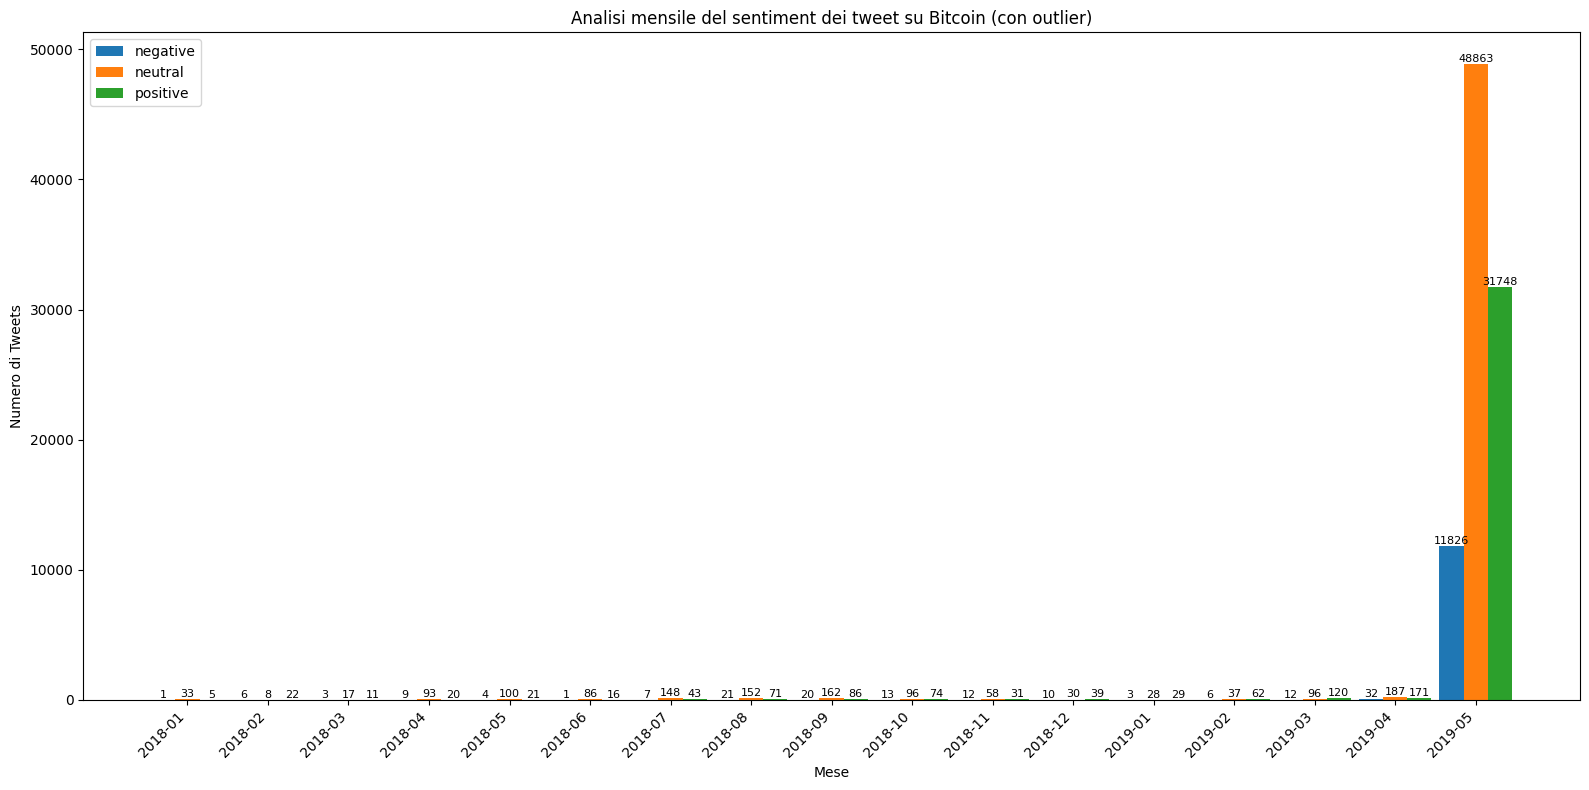

In [ ]:
#Grafico con outlier
create_sentiment_bar_chart(monthly_sentiment_pandas, 'Analisi mensile del sentiment dei tweet su Bitcoin (con outlier)')

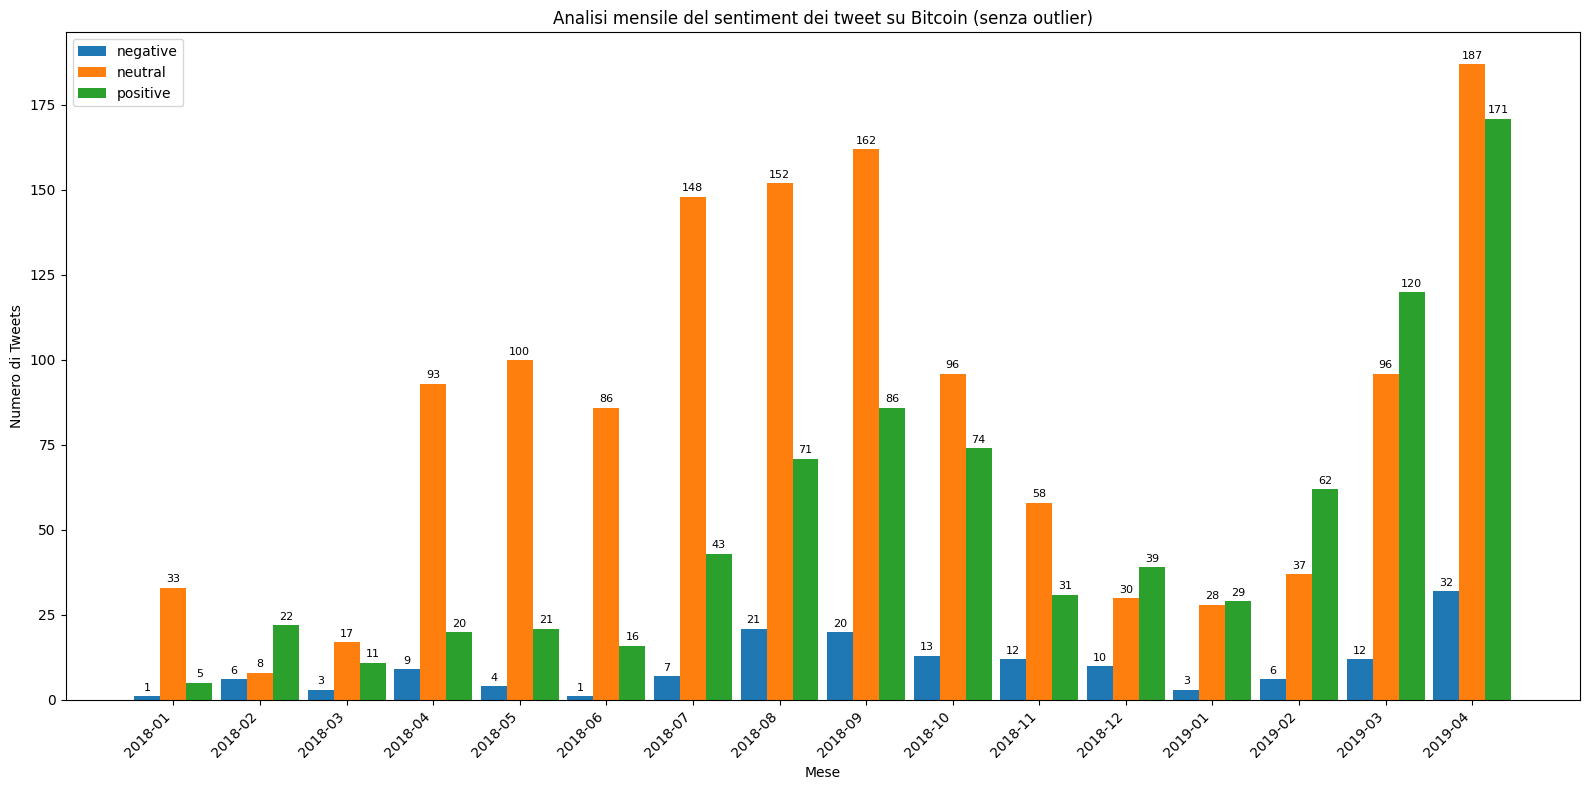

In [ ]:
#Grafico senza outlier
create_sentiment_bar_chart(no_outliers_df, 'Analisi mensile del sentiment dei tweet su Bitcoin (senza outlier)')

####Risultati

In [ ]:
print_monthly_sentiment_distribution(monthly_sentiment_pandas, 'Distribuzione mensile dei tweet per sentiment (con outlier)')

Distribuzione mensile dei tweet per sentiment (con outlier)
Sentiment: negative
Month: 2018-01, Number of Tweets: 1
Month: 2018-02, Number of Tweets: 6
Month: 2018-03, Number of Tweets: 3
Month: 2018-04, Number of Tweets: 9
Month: 2018-05, Number of Tweets: 4
Month: 2018-06, Number of Tweets: 1
Month: 2018-07, Number of Tweets: 7
Month: 2018-08, Number of Tweets: 21
Month: 2018-09, Number of Tweets: 20
Month: 2018-10, Number of Tweets: 13
Month: 2018-11, Number of Tweets: 12
Month: 2018-12, Number of Tweets: 10
Month: 2019-01, Number of Tweets: 3
Month: 2019-02, Number of Tweets: 6
Month: 2019-03, Number of Tweets: 12
Month: 2019-04, Number of Tweets: 32
Month: 2019-05, Number of Tweets: 11826

Sentiment: neutral
Month: 2018-01, Number of Tweets: 33
Month: 2018-02, Number of Tweets: 8
Month: 2018-03, Number of Tweets: 17
Month: 2018-04, Number of Tweets: 93
Month: 2018-05, Number of Tweets: 100
Month: 2018-06, Number of Tweets: 86
Month: 2018-07, Number of Tweets: 148
Month: 2018-08, N

In [ ]:
print_monthly_sentiment_distribution(no_outliers_df, 'Distribuzione mensile dei tweet per sentiment (senza outlier)')

Distribuzione mensile dei tweet per sentiment (senza outlier)
Sentiment: negative
Month: 2018-01, Number of Tweets: 1
Month: 2018-02, Number of Tweets: 6
Month: 2018-03, Number of Tweets: 3
Month: 2018-04, Number of Tweets: 9
Month: 2018-05, Number of Tweets: 4
Month: 2018-06, Number of Tweets: 1
Month: 2018-07, Number of Tweets: 7
Month: 2018-08, Number of Tweets: 21
Month: 2018-09, Number of Tweets: 20
Month: 2018-10, Number of Tweets: 13
Month: 2018-11, Number of Tweets: 12
Month: 2018-12, Number of Tweets: 10
Month: 2019-01, Number of Tweets: 3
Month: 2019-02, Number of Tweets: 6
Month: 2019-03, Number of Tweets: 12
Month: 2019-04, Number of Tweets: 32

Sentiment: neutral
Month: 2018-01, Number of Tweets: 33
Month: 2018-02, Number of Tweets: 8
Month: 2018-03, Number of Tweets: 17
Month: 2018-04, Number of Tweets: 93
Month: 2018-05, Number of Tweets: 100
Month: 2018-06, Number of Tweets: 86
Month: 2018-07, Number of Tweets: 148
Month: 2018-08, Number of Tweets: 152
Month: 2018-09, N

Commento

I risultati mostrano la distribuzione mensile dei tweet riguardanti Bitcoin suddivisi per sentiment positivo, negativo e neutro. Di seguito sono riportate le osservazioni per le analisi con e senza outlier.

**Distribuzione Mensile dei Tweet per Sentiment**

**Analisi con outlier**

**Sentiment Positivo:**
* Maggio 2019 mostra un picco estremo con 31748 tweet. Questo suggerisce un evento o un periodo di intensa attività positiva riguardante Bitcoin

**Sentiment Negativo:**
* Maggio 2019 presenta un picco estremo con 11826 tweet negativi, suggerendo una risposta intensa a un evento negativo o a una crisi specifica, che ha suscitato una risposta intensa da parte degli utenti

**Sentiment Neutro:**

* Maggio 2019 mostra un numero estremamente alto di tweet neutrali(48863), indicando un volume anomalo di attività neutra.

**Analisi senza outlier**

**Sentiment Positivo:** aprile 2019 è il mese con il numero più alto di tweet positivi (171), n valore molto più basso rispetto ai dati con outlier, suggerendo che il picco estremo era causato da valori anomali

**Sentiment Negativo:** senza outliers, il numero di tweet negativi a aprile 2019 è 32, il che è notevolmente inferiore rispetto ai dati con outlier. Questo suggerisce che il picco estremo osservato nei dati originali era causato da valori anomali

**Sentiment Neutro:** il numero di tweet neutrali a aprile 2019 è 187, molto inferiore ai dati osservati con outliers. Questo conferma che il picco alto nei dati originali era dovuto alla presenza di outlier

**Conclusioni**

**Variazione nel Sentiment:** le tendenze nel sentiment mostrano una differenza significativa tra i dati con e senza outlier. Mentre i dati con outlier indicano un picco estremo a maggio 2019, l'analisi senza outlier rivela che il volume di tweet è sostanzialmente più stabile e in linea con i dati dei mesi precedenti. Questo suggerisce che gli outlier hanno esagerato l'intensità del sentiment specificamente a maggio 2019, mentre i risultati per i mesi precedenti sono coerenti. I picchi possono essere correlati a eventi specifici nel mercato delle criptovalute, come cambiamenti regolamentari, sviluppi tecnologici o variazioni di prezzo significative.

**Impatto sul Mercato:** i picchi nel sentiment con outlier indicano un'intensa attività che potrebbe non essere rappresentativa delle tendenze reali. I dati senza outlier forniscono una visione più precisa dell'impatto degli eventi, mostrando che i picchi estremi nel sentiment positivo, negativo e neutro erano principalmente causati da outlier. Questo suggerisce che l'impatto reale degli eventi sul mercato è stato probabilmente meno significativo di quanto indicato dai dati con outlier.
Un volume elevato di tweet positivi o negativi può indicare rispettivamente ottimismo o pessimismo tra gli investitori e potrebbe influenzare il comportamento del mercato

**Eventi Significativi:** l'analisi senza outlier conferma che il picco estremo nel sentiment di maggio 2019 era dovuto a anomalie nei dati, piuttosto che a eventi significativi reali. Pertanto, l'analisi senza outlier fornisce una visione più accurata del sentiment reale verso Bitcoin, evitando interpretazioni fuorvianti basate su dati anomali specifici di maggio.
I picchi nei tweet a maggio 2019 suggeriscono che è importante indagare eventi specifici accaduti in quel periodo per comprendere meglio l'interazione degli utenti sui social media riguardo Bitcoin

In sintesi, l'analisi conferma che mentre ci sono stati picchi significativi nei dati con outlier, l'analisi senza outlier fornisce una rappresentazione più accurata e meno distorta delle tendenze reali nel sentiment verso Bitcoin. Gli outlier hanno avuto un impatto notevole sui dati del sentiment negativo, neutro e positivo, rendendo essenziale considerare questi effetti per una comprensione più chiara delle dinamiche di mercato.
Le variazioni mensili nel numero di tweet riflettono le fluttuazioni nel sentiment del mercato e possono fornire indicazioni utili per ulteriori analisi e strategie di trading

##Bonus

#### Acquisizione e preparazione dati storici Bitcoin

In [ ]:
btc_data = yf.download("BTC-USD", start="2013-01-01", end="2020-12-31")
btc_data.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


#### Integrazione dati Sentiment Giornaliero

In [ ]:
btc_df = spark.createDataFrame(btc_data)
btc_df = btc_df.withColumn("date", to_date(col("Date"))).select("date", "Open", "High", "Low", "Close", "Adj Close", "Volume")

####Calcolo variazioni giornaliere prezzi

In [ ]:
combined_df = daily_sentiment_df.join(btc_df, "date")

correlation_df = combined_df.select(
    "date", "positive_ratio", "negative_ratio",
    (col("Close") - col("Open")).alias("price_change")
)

#### Preparazione dati analisi correlazione

In [ ]:
correlation_pandas = correlation_df.toPandas()

correlation_pandas['date'] = pd.to_datetime(correlation_pandas['date'])
correlation_pandas['date_numeric'] = (correlation_pandas['date'] - correlation_pandas['date'].min()).dt.days

####Grafico

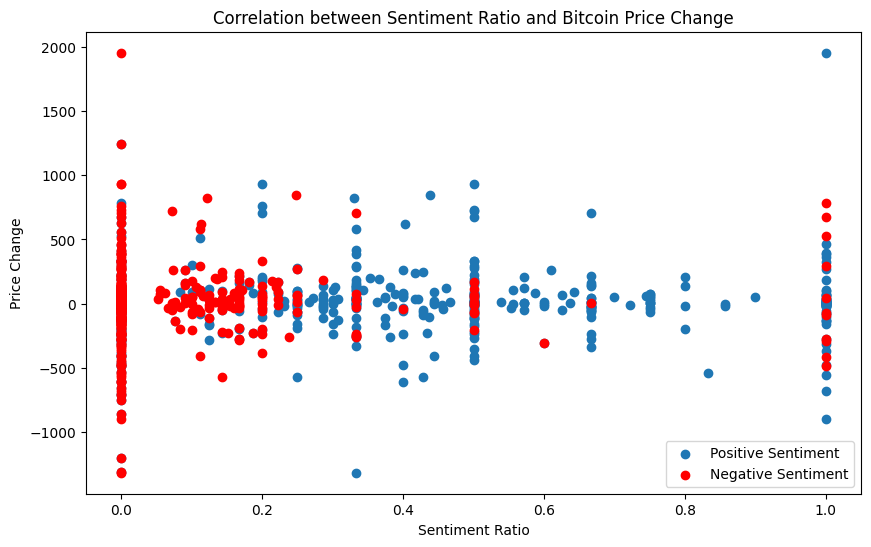

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(correlation_pandas["positive_ratio"], correlation_pandas["price_change"], label="Positive Sentiment")
plt.scatter(correlation_pandas["negative_ratio"], correlation_pandas["price_change"], label="Negative Sentiment", color='r')
plt.xlabel("Sentiment Ratio")
plt.ylabel("Price Change")
plt.title("Correlation between Sentiment Ratio and Bitcoin Price Change")
plt.legend()
plt.show()

####Risultati

In [ ]:
correlation_matrix = correlation_pandas[['positive_ratio', 'negative_ratio', 'price_change']].corr()
print(correlation_matrix)

                positive_ratio  negative_ratio  price_change
positive_ratio        1.000000       -0.228479      0.063168
negative_ratio       -0.228479        1.000000      0.043796
price_change          0.063168        0.043796      1.000000


Commento

I risultati della matrice di correlazione mostrano le correlazioni tra le variabili positive_ratio (rapporto di sentiment positivo), negative_ratio (rapporto di sentiment negativo) e price_change (variazione del prezzo di Bitcoin). Ecco alcune osservazioni basate sui valori di correlazione:

* **Correlazione tra positive_ratio e price_change**: Il coefficiente di correlazione tra positive_ratio e price_change è molto vicino a zero (0.063168), indicando una correlazione praticamente nulla. Ciò suggerisce che non c'è una relazione lineare chiara tra il sentiment positivo espresso nei tweet su Bitcoin e le variazioni del prezzo di Bitcoin. Questo potrebbe indicare che il sentiment positivo non è un predittore significativo delle variazioni di prezzo nel breve termine

* **Correlazione tra negative_ratio e price_change**: Il coefficiente di correlazione tra negative_ratio e price_change è ancora molto vicino a zero(0.043796). Questo suggerisce una correlazione debole tra il sentiment negativo espresso nei tweet e le variazioni di prezzo di Bitcoin. Anche in questo caso, non sembra esserci una forte relazione lineare tra il sentiment negativo e le variazioni del prezzo

* **Correlazione tra positive_ratio e negative_ratio**: Il coefficiente di correlazione tra positive_ratio e negative_ratio è moderatamente negativo (-0.228479). Questo indica una relazione inversa tra il sentiment positivo e negativo nei tweet su Bitcoin: quando aumenta il sentiment positivo, tende a diminuire il sentiment negativo e viceversa. Tuttavia, questa correlazione non è molto forte, suggerendo che il sentiment positivo e negativo possono variare indipendentemente l'uno dall'altro in molte occasioni

**Conclusione**

**Assenza di Relazione Significativa con il Prezzo:** i risultati indicano che il sentiment espresso nei tweet su Bitcoin non mostra una correlazione significativa con le variazioni del prezzo di Bitcoin nel periodo preso in esame. Questo suggerisce che altri fattori, come gli sviluppi tecnologici, le notizie di mercato o i cambiamenti normativi, potrebbero avere un impatto maggiore sulle fluttuazioni dei prezzi rispetto al sentiment espresso sui social media.

**Interdipendenza del Sentiment:** la correlazione negativa moderata tra positive_ratio e negative_ratio mostra che c'è una certa interdipendenza tra i sentiment positivi e negativi, ma non è abbastanza forte da considerare che uno escluda completamente l'altro.

In sintesi, mentre esiste una relazione inversa tra il sentiment positivo e negativo nei tweet su Bitcoin, non sembra esserci una correlazione significativa tra questi sentiment e le variazioni del prezzo di Bitcoin. Altri fattori esterni potrebbero essere più influenti sulle dinamiche dei prezzi

####Approfondimenti Statistici

In [ ]:
pearson_corr_positive, pearson_pval_positive = stats.pearsonr(correlation_pandas["positive_ratio"], correlation_pandas["price_change"])
print(f"Coefficiente di correlazione di Pearson tra positive_ratio e price_change: {pearson_corr_positive:.4f}")
print(f"P-value: {pearson_pval_positive:.4f}")

Coefficiente di correlazione di Pearson tra positive_ratio e price_change: 0.0632
P-value: 0.1734


In [ ]:
pearson_corr_negative, pearson_pval_negative = stats.pearsonr(correlation_pandas["negative_ratio"], correlation_pandas["price_change"])
print(f"Coefficiente di correlazione di Pearson tra negative_ratio e price_change: {pearson_corr_negative:.4f}")
print(f"P-value: {pearson_pval_negative:.4f}")

Coefficiente di correlazione di Pearson tra negative_ratio e price_change: 0.0438
P-value: 0.3455


Commento

**Interpretazione dei Risultati**

**Forza della Correlazione:**
* Il coefficiente di correlazione di Pearson tra positive_ratio e price_change è 0.0632, indicando una correlazione praticamente nulla. Questo significa che non c'è una relazione lineare evidente tra il rapporto di sentiment positivo espresso nei tweet su Bitcoin e le variazioni del prezzo di Bitcoin. In altre parole, le variazioni nel sentiment positivo non sono associate a variazioni di prezzo coerenti o prevedibili
* Il coefficiente di correlazione di Pearson tra negative_ratio e price_change è 0.0438, il che suggerisce una correlazione molto debole e positiva. Questo indica che un aumento nel rapporto di sentiment negativo nei tweet su Bitcoin è associato a un lieve aumento nelle variazioni del prezzo di Bitcoin. Tuttavia, questa correlazione è ancora molto vicina allo zero, indicando che non è significativa dal punto di vista statistico

**Significatività Statistica:** il p-value per la correlazione tra positive_ratio e price_change è 0.1734, mentre per negative_ratio e price_change è 0.3455. Entrambi i p-value sono molto superiori al livello di soglia comune di 0.05, suggerendo che le correlazioni osservate potrebbero essere casuali e non statisticamente significative. Ciò significa che i dati non forniscono prove sufficienti per respingere l'ipotesi nulla che non ci sia alcuna correlazione tra i sentiment sui social media e le variazioni di prezzo di Bitcoin

**Conclusioni**

**Assenza di Correlazione Significativa:** i risultati confermano che non c'è una correlazione significativa tra il sentiment (positivo o negativo) espresso nei tweet su Bitcoin e le variazioni del prezzo di Bitcoin. Questo suggerisce che i sentimenti positivi o negativi non sono predittori affidabili delle variazioni di prezzo nel breve termine

**Considerazioni sui Risultati:** è essenziale considerare una gamma più ampia di fattori e approcci analitici per comprendere meglio le dinamiche che influenzano il prezzo di Bitcoin. Le semplici correlazioni con il sentiment sui social media potrebbero non essere sufficienti per prevedere con precisione i movimenti di mercato.

Riassumendo, i risultati mostrano che né il sentiment positivo né quello negativo nei tweet hanno una correlazione significativa con le variazioni del prezzo di Bitcoin. Questo suggerisce che per prevedere i movimenti del prezzo di Bitcoin, è necessario un approccio più completo che consideri molteplici fattori oltre al sentiment sui social media